# Classical Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm
from sklearn.metrics import roc_auc_score


import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTAN

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
0
Tesla V100-PCIE-32GB


## Helper functions


### Binary Accuracy


In [4]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()

    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [5]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [6]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [7]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [8]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [9]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [10]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()
    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]
            predictions = model(inputs).squeeze(1)

            label = lab.to(dev)
            # label = label.unsqueeze(1)
            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [11]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [12]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Multi-Head Attention


In [13]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
    ):
        super(MultiHeadedAttention, self).__init__()
        assert (
            embed_dim % num_heads == 0
        ), f"Embedding dimension ({embed_dim}) should be divisible by number of heads ({num_heads})"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        # The linear layers for the query, key, and value projections
        self.linears = get_clones(nn.Linear(embed_dim, embed_dim, bias=use_bias), 3)
        # The linear layer to combine the heads
        self.combine_heads = nn.Linear(embed_dim, embed_dim, bias=use_bias)
        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        # 1) Do all the linear projections in batch from embed_dim => num_heads x dim_k
        query, key, value = [
            lin(x).view(batch_size, -1, self.num_heads, self.dim_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x: Tensor
        x, self.attn_weights = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)
        x = self.combine_heads(x)
        return x

### Feed-Forward Network


In [14]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(self, embed_dim: int, ffn_dim: int, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(embed_dim, ffn_dim)
        self.linear_2 = nn.Linear(ffn_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        x = self.linear_1(x).relu()
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Encoder


In [15]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
    ):
        super(Encoder, self).__init__()

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, mask=mask
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(embed_dim, ffn_dim, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output: Tensor = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [16]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        max_seq_len: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        ffn_dim=32,
        dropout=0.1,
    ):
        super(TextClassifier, self).__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        self.transformers = get_clones(
            Encoder(embed_dim, num_heads, ffn_dim), num_blocks
        )
        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # x = self.dropout1(x)

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [17]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

save_dir = ".models"
save_path = os.path.join(save_dir, "model_and_metrics_epoch_{}.pt")
os.makedirs(save_dir, exist_ok=True)


def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=30,
    lr=0.001,
    embed_dim=8,
    num_heads=4,
    num_blocks=6,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    dropout=0.1,
    tqdm_disabled=False,
):

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    # size = total_size
    # train_data = np.array(train_data)[
    #     np.random.choice(len(train_data), size=size, replace=False)
    # ].tolist()
    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("train pos: ", len([label for label, text in train_data if label == 1]))
    print("train neg: ", len([label for label, text in train_data if label == 2]))
    print("test pos: ", len([label for label, text in test_data if label == 1]))
    print("test neg: ", len([label for label, text in test_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")

    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    # train_loader = DataLoader(
    #     train_data,
    #     batch_sampler=batch_sampler(train_data, batch_size, tokenizer),
    #     collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    # )

    # test_loader = DataLoader(
    #     test_data,
    #     batch_sampler=batch_sampler(test_data, batch_size, tokenizer),
    #     collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    # )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        dropout=dropout,
        max_seq_len=max_seq_len,
    )
    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0

    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []

    dataset_size = len(train_loader.dataset)
    print(f"Training on {dataset_size} samples")
    print(f"batch_num = {len(train_loader)}")

    for iepoch in range(n_epochs):
        with tqdm(
            total=dataset_size,
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            disable=tqdm_disabled,
            miniters=dataset_size,
            # file=sys.stdout,
            # dynamic_ncols=False,
            # ascii=True,
            # position=0,
            # leave=True,
        ) as progress_bar:
            operation_start_time = time()

            # print(f"Epoch {iepoch+1}/{n_epochs}")
            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )
            # GPUtil.showUtilization()

            scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

            # print(f"Epoch: {iepoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
            # print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
            # print(f"\tTest Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%")

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if tqdm_disabled:
                ep_time = end_time - operation_start_time
                batch_time = len(train_loader.dataset) / ep_time

                print(
                    f"Epoch {iepoch+1:02}: {batch_time:.2f}batch/s, Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
                )

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1

            torch.save(
                {
                    "epoch": iepoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "train_loss": train_loss_list,
                    "train_acc": train_acc_list,
                    "train_auc": train_auc_list,
                    "test_loss": test_loss_list,
                    "test_acc": test_acc_list,
                    "test_auc": test_auc_list,
                },
                save_path.format(iepoch + 1),
            )

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [18]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main()

/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


train pos:  9985
train neg:  10015
test pos:  2515
test neg:  2485


++ There will be 6 transformer blocks
The model has 403,417 trainable parameters


Training on 20000 samples
batch_num = 625



Epoch   1/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   1/20:  71%|███████   | 14208/20000 [00:10<00:04, 1420.47batch/s]                                                  


Epoch   1/20:  71%|███████   | 14240/20000 [00:10<00:04, 1420.70batch/s]                                                  


Epoch   1/20:  72%|███████▏  | 14400/20000 [00:10<00:03, 1422.63batch/s]                                                  


Epoch   1/20:  73%|███████▎  | 14592/20000 [00:10<00:03, 1428.10batch/s]                                                  


Epoch   1/20:  74%|███████▍  | 14784/20000 [00:10<00:03, 1438.60batch/s]                                                  


Epoch   1/20:  75%|███████▍  | 14976/20000 [00:10<00:03, 1450.50batch/s]                                                  


Epoch   1/20:  76%|███████▌  | 15168/20000 [00:10<00:03, 1463.16batch/s]                                                  


Epoch   1/20:  77%|███████▋  | 15360/20000 [00:10<00:03, 1479.06batch/s]                                                  


Epoch   1/20:  78%|███████▊  | 15520/20000 [00:10<00:03, 1479.58batch/s]                                                  


Epoch   1/20:  79%|███████▊  | 15712/20000 [00:10<00:02, 1505.43batch/s]                                                  


Epoch   1/20:  80%|███████▉  | 15904/20000 [00:11<00:02, 1549.53batch/s]                                                  


Epoch   1/20:  80%|████████  | 16096/20000 [00:11<00:02, 1595.42batch/s]                                                  


Epoch   1/20:  81%|████████▏ | 16256/20000 [00:11<00:02, 1565.63batch/s]                                                  


Epoch   1/20:  82%|████████▏ | 16448/20000 [00:11<00:02, 1600.97batch/s]                                                  


Epoch   1/20:  83%|████████▎ | 16640/20000 [00:11<00:02, 1638.26batch/s]                                                  


Epoch   1/20:  84%|████████▍ | 16800/20000 [00:11<00:01, 1609.90batch/s]                                                  


Epoch   1/20:  85%|████████▍ | 16960/20000 [00:11<00:01, 1579.93batch/s]                                                  


Epoch   1/20:  86%|████████▌ | 17152/20000 [00:11<00:01, 1632.46batch/s]                                                  


Epoch   1/20:  87%|████████▋ | 17312/20000 [00:11<00:01, 1598.99batch/s]                                                  


Epoch   1/20:  88%|████████▊ | 17504/20000 [00:11<00:01, 1632.25batch/s]                                                  


Epoch   1/20:  88%|████████▊ | 17696/20000 [00:12<00:01, 1639.54batch/s]                                                  


Epoch   1/20:  89%|████████▉ | 17888/20000 [00:12<00:01, 1666.24batch/s]                                                  


Epoch   1/20:  90%|█████████ | 18048/20000 [00:12<00:01, 1639.24batch/s]                                                  


Epoch   1/20:  91%|█████████ | 18240/20000 [00:12<00:01, 1673.78batch/s]                                                  


Epoch   1/20:  92%|█████████▏| 18400/20000 [00:12<00:00, 1650.24batch/s]                                                  


Epoch   1/20:  93%|█████████▎| 18592/20000 [00:12<00:00, 1677.03batch/s]                                                  


Epoch   1/20:  94%|█████████▍| 18752/20000 [00:12<00:00, 1646.09batch/s]                                                  


Epoch   1/20:  94%|█████████▍| 18880/20000 [00:12<00:00, 1524.63batch/s]                                                  


Epoch   1/20:  95%|█████████▌| 19072/20000 [00:12<00:00, 1615.50batch/s]                                                  


Epoch   1/20:  96%|█████████▌| 19232/20000 [00:13<00:00, 1578.26batch/s]                                                  


Epoch   1/20:  97%|█████████▋| 19424/20000 [00:13<00:00, 1600.70batch/s]                                                  


Epoch   1/20:  98%|█████████▊| 19584/20000 [00:13<00:00, 1591.28batch/s]                                                  


Epoch   1/20:  99%|█████████▉| 19776/20000 [00:13<00:00, 1634.96batch/s]                                                  


Epoch   1/20: 100%|█████████▉| 19936/20000 [00:13<00:00, 1590.99batch/s]                                                  


Epoch   1/20: 100%|██████████| 20000/20000 [00:15<00:00, 1590.99batch/s, Epoch = 0m 15s, Loss = 0.6957|0.6932, Acc = 0.502


Epoch   1/20: 100%|██████████| 20000/20000 [00:15<00:00, 1327.11batch/s, Epoch = 0m 15s, Loss = 0.6957|0.6932, Acc = 0.502


Epoch   2/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   2/20: 100%|██████████| 20000/20000 [00:11<00:00, 1723.96batch/s]                                                  


Epoch   2/20: 100%|██████████| 20000/20000 [00:13<00:00, 1723.96batch/s, Epoch = 0m 13s, Loss = 0.6940|0.6911, Acc = 0.500


Epoch   2/20: 100%|██████████| 20000/20000 [00:13<00:00, 1508.43batch/s, Epoch = 0m 13s, Loss = 0.6940|0.6911, Acc = 0.500


Epoch   3/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   3/20: 100%|██████████| 20000/20000 [00:11<00:00, 1753.49batch/s]                                                  


Epoch   3/20: 100%|██████████| 20000/20000 [00:12<00:00, 1753.49batch/s, Epoch = 0m 12s, Loss = 0.6488|0.5535, Acc = 0.607


Epoch   3/20: 100%|██████████| 20000/20000 [00:12<00:00, 1546.78batch/s, Epoch = 0m 12s, Loss = 0.6488|0.5535, Acc = 0.607


Epoch   4/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   4/20: 100%|██████████| 20000/20000 [00:12<00:00, 1591.95batch/s]                                                  


Epoch   4/20: 100%|██████████| 20000/20000 [00:14<00:00, 1591.95batch/s, Epoch = 0m 14s, Loss = 0.5058|0.4487, Acc = 0.761


Epoch   4/20: 100%|██████████| 20000/20000 [00:14<00:00, 1409.65batch/s, Epoch = 0m 14s, Loss = 0.5058|0.4487, Acc = 0.761


Epoch   5/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   5/20: 100%|██████████| 20000/20000 [00:11<00:00, 1673.22batch/s]                                                  


Epoch   5/20: 100%|██████████| 20000/20000 [00:13<00:00, 1673.22batch/s, Epoch = 0m 13s, Loss = 0.4134|0.4088, Acc = 0.821


Epoch   5/20: 100%|██████████| 20000/20000 [00:13<00:00, 1509.29batch/s, Epoch = 0m 13s, Loss = 0.4134|0.4088, Acc = 0.821


Epoch   6/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   6/20:  54%|█████▍    | 10816/20000 [00:11<00:09, 957.08batch/s]                                                   


Epoch   6/20:  54%|█████▍    | 10848/20000 [00:11<00:09, 959.48batch/s]                                                   


Epoch   6/20:  55%|█████▌    | 11040/20000 [00:11<00:09, 969.07batch/s]                                                   


Epoch   6/20:  56%|█████▌    | 11168/20000 [00:11<00:09, 968.52batch/s]                                                   


Epoch   6/20:  56%|█████▋    | 11264/20000 [00:11<00:09, 964.32batch/s]                                                   


Epoch   6/20:  57%|█████▋    | 11360/20000 [00:11<00:09, 955.50batch/s]                                                   


Epoch   6/20:  57%|█████▋    | 11456/20000 [00:11<00:09, 944.89batch/s]                                                   


Epoch   6/20:  58%|█████▊    | 11552/20000 [00:12<00:08, 941.51batch/s]                                                   


Epoch   6/20:  58%|█████▊    | 11648/20000 [00:12<00:09, 922.60batch/s]                                                   


Epoch   6/20:  59%|█████▊    | 11744/20000 [00:12<00:08, 920.94batch/s]                                                   


Epoch   6/20:  59%|█████▉    | 11840/20000 [00:12<00:08, 915.81batch/s]                                                   


Epoch   6/20:  60%|█████▉    | 11936/20000 [00:12<00:09, 886.10batch/s]                                                   


Epoch   6/20:  60%|██████    | 12032/20000 [00:12<00:09, 877.41batch/s]                                                   


Epoch   6/20:  61%|██████    | 12128/20000 [00:12<00:09, 845.75batch/s]                                                   


Epoch   6/20:  61%|██████    | 12224/20000 [00:12<00:09, 834.52batch/s]                                                   


Epoch   6/20:  62%|██████▏   | 12320/20000 [00:12<00:09, 824.58batch/s]                                                   


Epoch   6/20:  62%|██████▏   | 12416/20000 [00:13<00:09, 807.16batch/s]                                                   


Epoch   6/20:  63%|██████▎   | 12544/20000 [00:13<00:08, 845.78batch/s]                                                   


Epoch   6/20:  63%|██████▎   | 12640/20000 [00:13<00:08, 847.20batch/s]                                                   


Epoch   6/20:  64%|██████▎   | 12736/20000 [00:13<00:08, 848.05batch/s]                                                   


Epoch   6/20:  64%|██████▍   | 12832/20000 [00:13<00:08, 843.98batch/s]                                                   


Epoch   6/20:  65%|██████▍   | 12928/20000 [00:13<00:08, 847.40batch/s]                                                   


Epoch   6/20:  65%|██████▌   | 13024/20000 [00:13<00:08, 848.85batch/s]                                                   


Epoch   6/20:  66%|██████▌   | 13120/20000 [00:13<00:08, 851.54batch/s]                                                   


Epoch   6/20:  66%|██████▌   | 13216/20000 [00:14<00:08, 846.96batch/s]                                                   


Epoch   6/20:  67%|██████▋   | 13344/20000 [00:14<00:07, 942.32batch/s]                                                   


Epoch   6/20:  68%|██████▊   | 13536/20000 [00:14<00:05, 1169.66batch/s]                                                  


Epoch   6/20:  69%|██████▊   | 13728/20000 [00:14<00:04, 1362.25batch/s]                                                  


Epoch   6/20:  70%|██████▉   | 13920/20000 [00:14<00:04, 1498.96batch/s]                                                  


Epoch   6/20:  71%|███████   | 14112/20000 [00:14<00:03, 1599.35batch/s]                                                  


Epoch   6/20:  71%|███████▏  | 14272/20000 [00:14<00:03, 1587.05batch/s]                                                  


Epoch   6/20:  72%|███████▏  | 14464/20000 [00:14<00:03, 1579.31batch/s]                                                  


Epoch   6/20:  73%|███████▎  | 14592/20000 [00:14<00:03, 1376.42batch/s]                                                  


Epoch   6/20:  73%|███████▎  | 14688/20000 [00:15<00:04, 1248.30batch/s]                                                  


Epoch   6/20:  74%|███████▍  | 14816/20000 [00:15<00:04, 1171.29batch/s]                                                  


Epoch   6/20:  75%|███████▍  | 14912/20000 [00:15<00:04, 1072.43batch/s]                                                  


Epoch   6/20:  75%|███████▌  | 15008/20000 [00:15<00:04, 1013.06batch/s]                                                  


Epoch   6/20:  76%|███████▌  | 15136/20000 [00:15<00:04, 1023.29batch/s]                                                  


Epoch   6/20:  76%|███████▌  | 15232/20000 [00:15<00:04, 965.49batch/s]                                                   


Epoch   6/20:  77%|███████▋  | 15328/20000 [00:15<00:05, 924.43batch/s]                                                   


Epoch   6/20:  77%|███████▋  | 15424/20000 [00:15<00:05, 887.44batch/s]                                                   


Epoch   6/20:  78%|███████▊  | 15520/20000 [00:15<00:05, 892.90batch/s]                                                   


Epoch   6/20:  78%|███████▊  | 15616/20000 [00:16<00:04, 899.86batch/s]                                                   


Epoch   6/20:  79%|███████▊  | 15712/20000 [00:16<00:04, 885.21batch/s]                                                   


Epoch   6/20:  79%|███████▉  | 15808/20000 [00:16<00:04, 891.10batch/s]                                                   


Epoch   6/20:  80%|███████▉  | 15904/20000 [00:16<00:04, 907.36batch/s]                                                   


Epoch   6/20:  80%|████████  | 16000/20000 [00:16<00:04, 875.38batch/s]                                                   


Epoch   6/20:  81%|████████  | 16128/20000 [00:16<00:04, 902.37batch/s]                                                   


Epoch   6/20:  81%|████████▏ | 16256/20000 [00:16<00:03, 955.09batch/s]                                                   


Epoch   6/20:  82%|████████▏ | 16384/20000 [00:16<00:03, 969.84batch/s]                                                   


Epoch   6/20:  83%|████████▎ | 16512/20000 [00:17<00:03, 956.04batch/s]                                                   


Epoch   6/20:  83%|████████▎ | 16608/20000 [00:17<00:03, 918.40batch/s]                                                   


Epoch   6/20:  84%|████████▎ | 16736/20000 [00:17<00:03, 922.01batch/s]                                                   


Epoch   6/20:  84%|████████▍ | 16832/20000 [00:17<00:03, 922.18batch/s]                                                   


Epoch   6/20:  85%|████████▍ | 16960/20000 [00:17<00:03, 983.90batch/s]                                                   


Epoch   6/20:  85%|████████▌ | 17088/20000 [00:17<00:02, 1004.97batch/s]                                                  


Epoch   6/20:  86%|████████▌ | 17216/20000 [00:17<00:02, 1057.04batch/s]                                                  


Epoch   6/20:  87%|████████▋ | 17344/20000 [00:17<00:02, 1046.40batch/s]                                                  


Epoch   6/20:  87%|████████▋ | 17440/20000 [00:17<00:02, 1010.27batch/s]                                                  


Epoch   6/20:  88%|████████▊ | 17568/20000 [00:18<00:02, 1018.61batch/s]                                                  


Epoch   6/20:  88%|████████▊ | 17696/20000 [00:18<00:02, 1009.16batch/s]                                                  


Epoch   6/20:  89%|████████▉ | 17824/20000 [00:18<00:02, 1006.41batch/s]                                                  


Epoch   6/20:  90%|████████▉ | 17920/20000 [00:18<00:02, 967.43batch/s]                                                   


Epoch   6/20:  90%|█████████ | 18016/20000 [00:18<00:02, 953.24batch/s]                                                   


Epoch   6/20:  91%|█████████ | 18112/20000 [00:18<00:02, 923.94batch/s]                                                   


Epoch   6/20:  91%|█████████ | 18240/20000 [00:18<00:01, 927.69batch/s]                                                   


Epoch   6/20:  92%|█████████▏| 18336/20000 [00:18<00:01, 904.21batch/s]                                                   


Epoch   6/20:  92%|█████████▏| 18432/20000 [00:19<00:01, 909.14batch/s]                                                   


Epoch   6/20:  93%|█████████▎| 18528/20000 [00:19<00:01, 922.73batch/s]                                                   


Epoch   6/20:  93%|█████████▎| 18624/20000 [00:19<00:01, 918.81batch/s]                                                   


Epoch   6/20:  94%|█████████▍| 18752/20000 [00:19<00:01, 961.37batch/s]                                                   


Epoch   6/20:  94%|█████████▍| 18880/20000 [00:19<00:01, 985.05batch/s]                                                   


Epoch   6/20:  95%|█████████▍| 18976/20000 [00:19<00:01, 956.46batch/s]                                                   


Epoch   6/20:  96%|█████████▌| 19104/20000 [00:19<00:00, 974.07batch/s]                                                   


Epoch   6/20:  96%|█████████▌| 19200/20000 [00:19<00:00, 934.56batch/s]                                                   


Epoch   6/20:  96%|█████████▋| 19296/20000 [00:19<00:00, 912.88batch/s]                                                   


Epoch   6/20:  97%|█████████▋| 19392/20000 [00:20<00:00, 891.93batch/s]                                                   


Epoch   6/20:  97%|█████████▋| 19488/20000 [00:20<00:00, 899.68batch/s]                                                   


Epoch   6/20:  98%|█████████▊| 19616/20000 [00:20<00:00, 955.58batch/s]                                                   


Epoch   6/20:  99%|█████████▊| 19712/20000 [00:20<00:00, 950.67batch/s]                                                   


Epoch   6/20:  99%|█████████▉| 19840/20000 [00:20<00:00, 976.37batch/s]                                                   


Epoch   6/20: 100%|█████████▉| 19936/20000 [00:20<00:00, 951.19batch/s]                                                   


Epoch   6/20: 100%|██████████| 20000/20000 [00:21<00:00, 951.19batch/s, Epoch = 0m 21s, Loss = 0.3620|0.3985, Acc = 0.849|


Epoch   6/20: 100%|██████████| 20000/20000 [00:21<00:00, 909.27batch/s, Epoch = 0m 21s, Loss = 0.3620|0.3985, Acc = 0.849|


Epoch   7/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   7/20:  90%|█████████ | 18016/20000 [00:19<00:02, 932.98batch/s]                                                   


Epoch   7/20:  90%|█████████ | 18048/20000 [00:19<00:02, 933.35batch/s]                                                   


Epoch   7/20:  91%|█████████ | 18144/20000 [00:19<00:01, 932.37batch/s]                                                   


Epoch   7/20:  91%|█████████ | 18240/20000 [00:19<00:01, 929.85batch/s]                                                   


Epoch   7/20:  92%|█████████▏| 18336/20000 [00:19<00:01, 927.81batch/s]                                                   


Epoch   7/20:  92%|█████████▏| 18432/20000 [00:19<00:01, 925.72batch/s]                                                   


Epoch   7/20:  93%|█████████▎| 18528/20000 [00:19<00:01, 926.66batch/s]                                                   


Epoch   7/20:  93%|█████████▎| 18624/20000 [00:20<00:01, 926.18batch/s]                                                   


Epoch   7/20:  94%|█████████▍| 18752/20000 [00:20<00:01, 929.03batch/s]                                                   


Epoch   7/20:  94%|█████████▍| 18848/20000 [00:20<00:01, 929.82batch/s]                                                   


Epoch   7/20:  95%|█████████▍| 18976/20000 [00:20<00:01, 939.33batch/s]                                                   


Epoch   7/20:  96%|█████████▌| 19104/20000 [00:20<00:00, 966.06batch/s]                                                   


Epoch   7/20:  96%|█████████▌| 19232/20000 [00:20<00:00, 986.23batch/s]                                                   


Epoch   7/20:  97%|█████████▋| 19360/20000 [00:20<00:00, 989.64batch/s]                                                   


Epoch   7/20:  97%|█████████▋| 19456/20000 [00:20<00:00, 957.28batch/s]                                                   


Epoch   7/20:  98%|█████████▊| 19552/20000 [00:20<00:00, 922.19batch/s]                                                   


Epoch   7/20:  98%|█████████▊| 19648/20000 [00:21<00:00, 889.12batch/s]                                                   


Epoch   7/20:  99%|█████████▊| 19744/20000 [00:21<00:00, 875.07batch/s]                                                   


Epoch   7/20:  99%|█████████▉| 19872/20000 [00:21<00:00, 897.86batch/s]                                                   


Epoch   7/20: 100%|█████████▉| 19968/20000 [00:21<00:00, 906.05batch/s]                                                   


Epoch   7/20: 100%|██████████| 20000/20000 [00:22<00:00, 906.05batch/s, Epoch = 0m 22s, Loss = 0.3562|0.3960, Acc = 0.852|


Epoch   7/20: 100%|██████████| 20000/20000 [00:22<00:00, 873.88batch/s, Epoch = 0m 22s, Loss = 0.3562|0.3960, Acc = 0.852|


Epoch   8/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   8/20: 100%|██████████| 20000/20000 [00:13<00:00, 1490.87batch/s]                                                  


Epoch   8/20: 100%|██████████| 20000/20000 [00:14<00:00, 1490.87batch/s, Epoch = 0m 14s, Loss = 0.3497|0.3957, Acc = 0.855


Epoch   8/20: 100%|██████████| 20000/20000 [00:14<00:00, 1348.07batch/s, Epoch = 0m 14s, Loss = 0.3497|0.3957, Acc = 0.855


Epoch   9/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch   9/20:  84%|████████▍ | 16800/20000 [00:11<00:02, 1449.28batch/s]                                                  


Epoch   9/20:  84%|████████▍ | 16832/20000 [00:11<00:02, 1448.63batch/s]                                                  


Epoch   9/20:  85%|████████▍ | 16928/20000 [00:11<00:02, 1441.58batch/s]                                                  


Epoch   9/20:  85%|████████▌ | 17024/20000 [00:11<00:02, 1431.65batch/s]                                                  


Epoch   9/20:  86%|████████▌ | 17120/20000 [00:11<00:02, 1417.72batch/s]                                                  


Epoch   9/20:  86%|████████▌ | 17216/20000 [00:12<00:01, 1395.10batch/s]                                                  


Epoch   9/20:  87%|████████▋ | 17312/20000 [00:12<00:01, 1370.92batch/s]                                                  


Epoch   9/20:  87%|████████▋ | 17408/20000 [00:12<00:01, 1335.99batch/s]                                                  


Epoch   9/20:  88%|████████▊ | 17504/20000 [00:12<00:01, 1297.07batch/s]                                                  


Epoch   9/20:  88%|████████▊ | 17600/20000 [00:12<00:01, 1240.20batch/s]                                                  


Epoch   9/20:  88%|████████▊ | 17696/20000 [00:12<00:01, 1160.80batch/s]                                                  


Epoch   9/20:  89%|████████▉ | 17792/20000 [00:12<00:02, 1101.63batch/s]                                                  


Epoch   9/20:  89%|████████▉ | 17888/20000 [00:12<00:02, 1046.88batch/s]                                                  


Epoch   9/20:  90%|████████▉ | 17984/20000 [00:12<00:02, 1002.25batch/s]                                                  


Epoch   9/20:  90%|█████████ | 18080/20000 [00:13<00:02, 951.93batch/s]                                                   


Epoch   9/20:  91%|█████████ | 18176/20000 [00:13<00:01, 918.77batch/s]                                                   


Epoch   9/20:  91%|█████████▏| 18272/20000 [00:13<00:01, 915.87batch/s]                                                   


Epoch   9/20:  92%|█████████▏| 18368/20000 [00:13<00:01, 882.75batch/s]                                                   


Epoch   9/20:  92%|█████████▏| 18464/20000 [00:13<00:01, 888.72batch/s]                                                   


Epoch   9/20:  93%|█████████▎| 18560/20000 [00:13<00:01, 893.47batch/s]                                                   


Epoch   9/20:  93%|█████████▎| 18656/20000 [00:13<00:01, 885.79batch/s]                                                   


Epoch   9/20:  94%|█████████▍| 18752/20000 [00:13<00:01, 857.48batch/s]                                                   


Epoch   9/20:  94%|█████████▍| 18848/20000 [00:14<00:01, 836.42batch/s]                                                   


Epoch   9/20:  95%|█████████▍| 18944/20000 [00:14<00:01, 850.62batch/s]                                                   


Epoch   9/20:  95%|█████████▌| 19040/20000 [00:14<00:01, 837.36batch/s]                                                   


Epoch   9/20:  96%|█████████▌| 19136/20000 [00:14<00:01, 834.65batch/s]                                                   


Epoch   9/20:  96%|█████████▌| 19232/20000 [00:14<00:00, 843.82batch/s]                                                   


Epoch   9/20:  97%|█████████▋| 19328/20000 [00:14<00:00, 848.74batch/s]                                                   


Epoch   9/20:  97%|█████████▋| 19424/20000 [00:14<00:00, 827.72batch/s]                                                   


Epoch   9/20:  98%|█████████▊| 19520/20000 [00:14<00:00, 839.60batch/s]                                                   


Epoch   9/20:  98%|█████████▊| 19616/20000 [00:14<00:00, 862.18batch/s]                                                   


Epoch   9/20:  99%|█████████▊| 19744/20000 [00:15<00:00, 902.13batch/s]                                                   


Epoch   9/20:  99%|█████████▉| 19872/20000 [00:15<00:00, 950.68batch/s]                                                   


Epoch   9/20: 100%|█████████▉| 19968/20000 [00:15<00:00, 911.47batch/s]                                                   


Epoch   9/20: 100%|██████████| 20000/20000 [00:16<00:00, 911.47batch/s, Epoch = 0m 16s, Loss = 0.3453|0.3951, Acc = 0.857|


Epoch   9/20: 100%|██████████| 20000/20000 [00:16<00:00, 1189.56batch/s, Epoch = 0m 16s, Loss = 0.3453|0.3951, Acc = 0.857


Epoch  10/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  10/20:  81%|████████▏ | 16256/20000 [00:14<00:03, 1099.44batch/s]                                                  


Epoch  10/20:  81%|████████▏ | 16288/20000 [00:14<00:03, 1099.79batch/s]                                                  


Epoch  10/20:  82%|████████▏ | 16480/20000 [00:14<00:03, 1106.23batch/s]                                                  


Epoch  10/20:  83%|████████▎ | 16640/20000 [00:15<00:03, 1110.41batch/s]                                                  


Epoch  10/20:  84%|████████▍ | 16800/20000 [00:15<00:02, 1119.32batch/s]                                                  


Epoch  10/20:  85%|████████▍ | 16992/20000 [00:15<00:02, 1135.83batch/s]                                                  


Epoch  10/20:  86%|████████▌ | 17184/20000 [00:15<00:02, 1161.35batch/s]                                                  


Epoch  10/20:  87%|████████▋ | 17344/20000 [00:15<00:02, 1177.71batch/s]                                                  


Epoch  10/20:  88%|████████▊ | 17536/20000 [00:15<00:02, 1215.54batch/s]                                                  


Epoch  10/20:  89%|████████▊ | 17728/20000 [00:15<00:01, 1271.21batch/s]                                                  


Epoch  10/20:  90%|████████▉ | 17920/20000 [00:15<00:01, 1321.68batch/s]                                                  


Epoch  10/20:  91%|█████████ | 18112/20000 [00:15<00:01, 1372.51batch/s]                                                  


Epoch  10/20:  92%|█████████▏| 18304/20000 [00:16<00:01, 1440.83batch/s]                                                  


Epoch  10/20:  92%|█████████▏| 18496/20000 [00:16<00:01, 1495.29batch/s]                                                  


Epoch  10/20:  93%|█████████▎| 18688/20000 [00:16<00:00, 1569.73batch/s]                                                  


Epoch  10/20:  94%|█████████▍| 18880/20000 [00:16<00:00, 1639.48batch/s]                                                  


Epoch  10/20:  95%|█████████▌| 19072/20000 [00:16<00:00, 1685.13batch/s]                                                  


Epoch  10/20:  96%|█████████▋| 19264/20000 [00:16<00:00, 1691.64batch/s]                                                  


Epoch  10/20:  97%|█████████▋| 19424/20000 [00:16<00:00, 1659.00batch/s]                                                  


Epoch  10/20:  98%|█████████▊| 19616/20000 [00:16<00:00, 1704.61batch/s]                                                  


Epoch  10/20:  99%|█████████▉| 19808/20000 [00:16<00:00, 1749.24batch/s]                                                  


Epoch  10/20: 100%|█████████▉| 19968/20000 [00:16<00:00, 1661.48batch/s]                                                  


Epoch  10/20: 100%|██████████| 20000/20000 [00:18<00:00, 1661.48batch/s, Epoch = 0m 18s, Loss = 0.3403|0.3934, Acc = 0.860


Epoch  10/20: 100%|██████████| 20000/20000 [00:18<00:00, 1090.54batch/s, Epoch = 0m 18s, Loss = 0.3403|0.3934, Acc = 0.860


Epoch  11/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  11/20: 100%|██████████| 20000/20000 [00:14<00:00, 1368.87batch/s]                                                  


Epoch  11/20: 100%|██████████| 20000/20000 [00:15<00:00, 1368.87batch/s, Epoch = 0m 15s, Loss = 0.3378|0.3944, Acc = 0.862


Epoch  11/20: 100%|██████████| 20000/20000 [00:15<00:00, 1252.25batch/s, Epoch = 0m 15s, Loss = 0.3378|0.3944, Acc = 0.862


Epoch  12/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  12/20:  82%|████████▏ | 16384/20000 [00:10<00:02, 1563.52batch/s]                                                  


Epoch  12/20:  82%|████████▏ | 16416/20000 [00:10<00:02, 1566.27batch/s]                                                  


Epoch  12/20:  83%|████████▎ | 16576/20000 [00:10<00:02, 1562.34batch/s]                                                  


Epoch  12/20:  84%|████████▍ | 16768/20000 [00:10<00:02, 1565.00batch/s]                                                  


Epoch  12/20:  85%|████████▍ | 16960/20000 [00:10<00:01, 1572.07batch/s]                                                  


Epoch  12/20:  86%|████████▌ | 17152/20000 [00:10<00:01, 1582.96batch/s]                                                  


Epoch  12/20:  87%|████████▋ | 17376/20000 [00:11<00:01, 1601.41batch/s]                                                  


Epoch  12/20:  88%|████████▊ | 17568/20000 [00:11<00:01, 1615.06batch/s]                                                  


Epoch  12/20:  89%|████████▉ | 17760/20000 [00:11<00:01, 1596.58batch/s]                                                  


Epoch  12/20:  90%|████████▉ | 17920/20000 [00:11<00:01, 1587.94batch/s]                                                  


Epoch  12/20:  91%|█████████ | 18112/20000 [00:11<00:01, 1621.11batch/s]                                                  


Epoch  12/20:  92%|█████████▏| 18304/20000 [00:11<00:01, 1650.29batch/s]                                                  


Epoch  12/20:  92%|█████████▏| 18496/20000 [00:11<00:00, 1693.72batch/s]                                                  


Epoch  12/20:  93%|█████████▎| 18688/20000 [00:11<00:00, 1724.19batch/s]                                                  


Epoch  12/20:  94%|█████████▍| 18880/20000 [00:11<00:00, 1756.92batch/s]                                                  


Epoch  12/20:  95%|█████████▌| 19072/20000 [00:12<00:00, 1709.79batch/s]                                                  


Epoch  12/20:  96%|█████████▋| 19264/20000 [00:12<00:00, 1716.35batch/s]                                                  


Epoch  12/20:  97%|█████████▋| 19456/20000 [00:12<00:00, 1702.36batch/s]                                                  


Epoch  12/20:  98%|█████████▊| 19648/20000 [00:12<00:00, 1721.28batch/s]                                                  


Epoch  12/20:  99%|█████████▉| 19840/20000 [00:12<00:00, 1770.88batch/s]                                                  


Epoch  12/20: 100%|██████████| 20000/20000 [00:13<00:00, 1770.88batch/s, Epoch = 0m 13s, Loss = 0.3374|0.3925, Acc = 0.860


Epoch  12/20: 100%|██████████| 20000/20000 [00:13<00:00, 1440.11batch/s, Epoch = 0m 13s, Loss = 0.3374|0.3925, Acc = 0.860


Epoch  13/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  13/20: 100%|██████████| 20000/20000 [00:11<00:00, 1732.66batch/s]                                                  


Epoch  13/20: 100%|██████████| 20000/20000 [00:13<00:00, 1732.66batch/s, Epoch = 0m 13s, Loss = 0.3404|0.3940, Acc = 0.861


Epoch  13/20: 100%|██████████| 20000/20000 [00:13<00:00, 1519.03batch/s, Epoch = 0m 13s, Loss = 0.3404|0.3940, Acc = 0.861


Epoch  14/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  14/20: 100%|██████████| 20000/20000 [00:12<00:00, 1657.80batch/s]                                                  


Epoch  14/20: 100%|██████████| 20000/20000 [00:13<00:00, 1657.80batch/s, Epoch = 0m 13s, Loss = 0.3384|0.3941, Acc = 0.864


Epoch  14/20: 100%|██████████| 20000/20000 [00:13<00:00, 1462.75batch/s, Epoch = 0m 13s, Loss = 0.3384|0.3941, Acc = 0.864


Epoch  15/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  15/20: 100%|██████████| 20000/20000 [00:12<00:00, 1621.91batch/s]                                                  


Epoch  15/20: 100%|██████████| 20000/20000 [00:13<00:00, 1621.91batch/s, Epoch = 0m 13s, Loss = 0.3355|0.3942, Acc = 0.862


Epoch  15/20: 100%|██████████| 20000/20000 [00:13<00:00, 1451.74batch/s, Epoch = 0m 13s, Loss = 0.3355|0.3942, Acc = 0.862


Epoch  16/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  16/20: 100%|██████████| 20000/20000 [00:12<00:00, 1641.33batch/s]                                                  


Epoch  16/20: 100%|██████████| 20000/20000 [00:13<00:00, 1641.33batch/s, Epoch = 0m 13s, Loss = 0.3367|0.3958, Acc = 0.862


Epoch  16/20: 100%|██████████| 20000/20000 [00:13<00:00, 1461.88batch/s, Epoch = 0m 13s, Loss = 0.3367|0.3958, Acc = 0.862


Epoch  17/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  17/20: 100%|██████████| 20000/20000 [00:11<00:00, 1732.43batch/s]                                                  


Epoch  17/20: 100%|██████████| 20000/20000 [00:12<00:00, 1732.43batch/s, Epoch = 0m 12s, Loss = 0.3397|0.3943, Acc = 0.862


Epoch  17/20: 100%|██████████| 20000/20000 [00:12<00:00, 1550.59batch/s, Epoch = 0m 12s, Loss = 0.3397|0.3943, Acc = 0.862


Epoch  18/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  18/20: 100%|██████████| 20000/20000 [00:11<00:00, 1704.95batch/s]                                                  


Epoch  18/20: 100%|██████████| 20000/20000 [00:13<00:00, 1704.95batch/s, Epoch = 0m 13s, Loss = 0.3347|0.3958, Acc = 0.862


Epoch  18/20: 100%|██████████| 20000/20000 [00:13<00:00, 1501.61batch/s, Epoch = 0m 13s, Loss = 0.3347|0.3958, Acc = 0.862


Epoch  19/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  19/20: 100%|██████████| 20000/20000 [00:11<00:00, 1690.51batch/s]                                                  


Epoch  19/20: 100%|██████████| 20000/20000 [00:13<00:00, 1690.51batch/s, Epoch = 0m 13s, Loss = 0.3363|0.3916, Acc = 0.861


Epoch  19/20: 100%|██████████| 20000/20000 [00:13<00:00, 1525.29batch/s, Epoch = 0m 13s, Loss = 0.3363|0.3916, Acc = 0.861


Epoch  20/20:   0%|          | 0/20000 [00:00<?, ?batch/s]                                                                


Epoch  20/20: 100%|██████████| 20000/20000 [00:11<00:00, 1700.29batch/s]                                                  


Epoch  20/20: 100%|██████████| 20000/20000 [00:13<00:00, 1700.29batch/s, Epoch = 0m 13s, Loss = 0.3405|0.3916, Acc = 0.859


Epoch  20/20: 100%|██████████| 20000/20000 [00:13<00:00, 1498.66batch/s, Epoch = 0m 13s, Loss = 0.3405|0.3916, Acc = 0.859

TOTAL TIME = 301.46s
BEST ACC = 0.83% AT EPOCH 12
BEST AUC = 90.60 AT EPOCH 19


## Evaluation


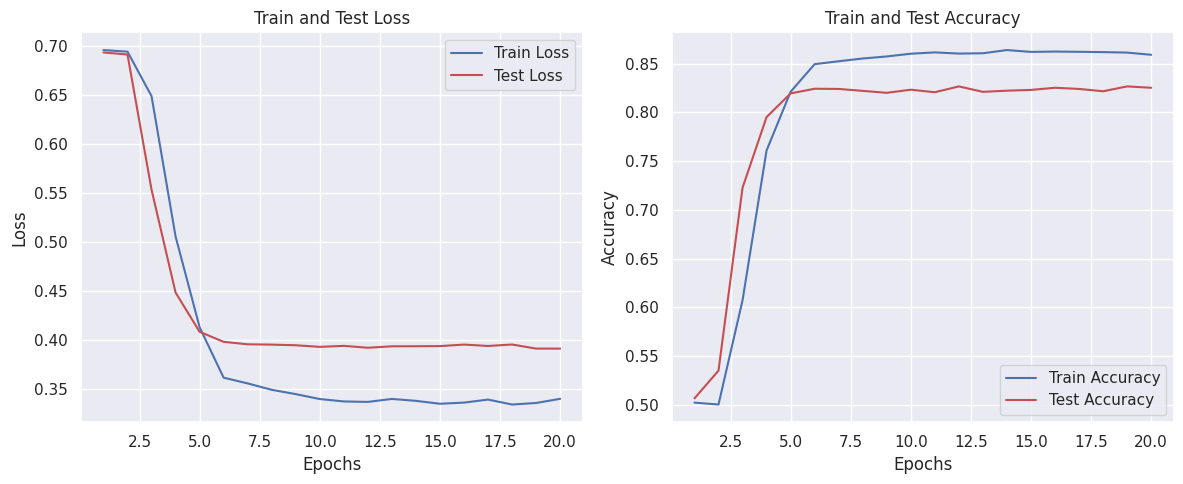

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

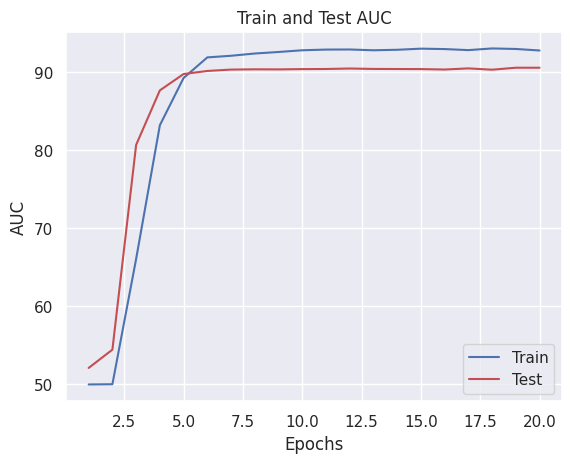

In [20]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [21]:
checkpoint = torch.load(
    ".models/model_and_metrics_epoch_10.pt"
)  # Replace x with the epoch number

# Load the metrics
epoch = checkpoint["epoch"]
train_loss = checkpoint["train_loss"]
train_acc = checkpoint["train_acc"]
train_auc = checkpoint["train_auc"]
test_loss = checkpoint["test_loss"]
test_acc = checkpoint["test_acc"]
test_auc = checkpoint["test_auc"]

test_acc

[0.5067675159235668,
 0.5352308917197452,
 0.7227308917197452,
 0.7951831210191083,
 0.8194665605095541,
 0.8242436305732485,
 0.8240445859872612,
 0.8220541401273885,
 0.8200636942675159,
 0.8232484076433121]

In [22]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(epochs, train_auc, label="Classical Training", color="purple")
# ax.plot(epochs, test_auc, label="Classical Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)